# Comparison of Dina startup to TokaMaker (recreate EQ fixed boundary)

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk
from OpenFUSIONToolkit.util import mu0

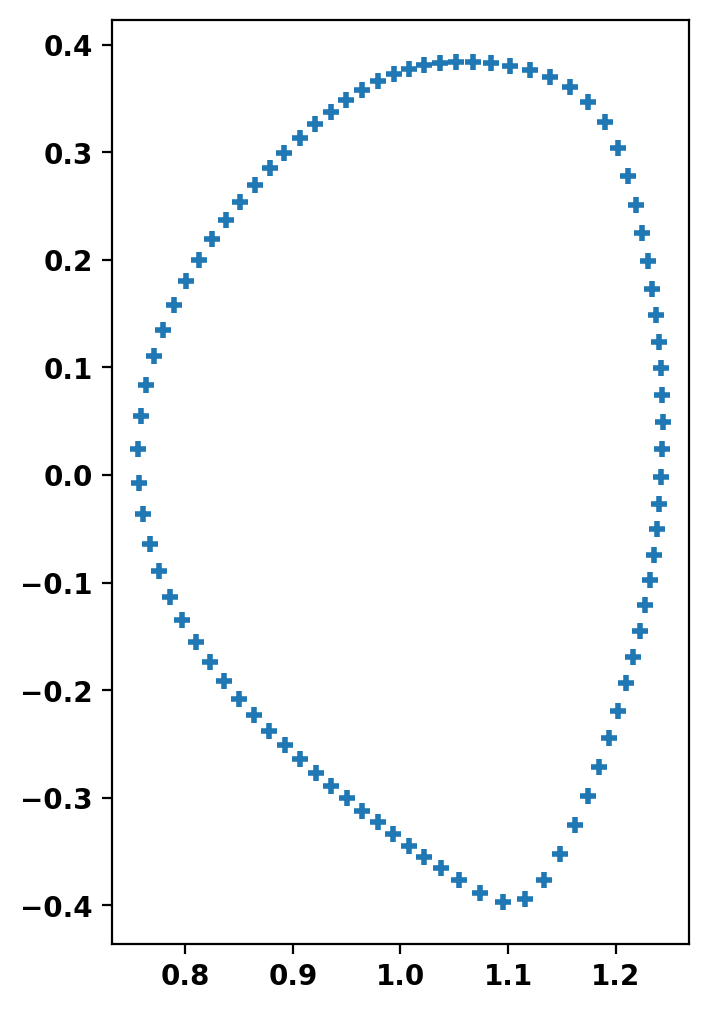

In [3]:
time_pt = 4000
mesh_dx = 0.0125
EQ_in = read_eqdsk('1MA_eqdsk_currs/{0:d}msec/nsf_ntt.{0:06d}'.format(time_pt))
LCFS_contour = EQ_in['rzout'][:-1,:]

Assembling regions:
  # of unique points    = 160
  # of unique segments  = 1
Generating mesh:
  # of points  = 2842
  # of cells   = 5522
  # of regions = 1


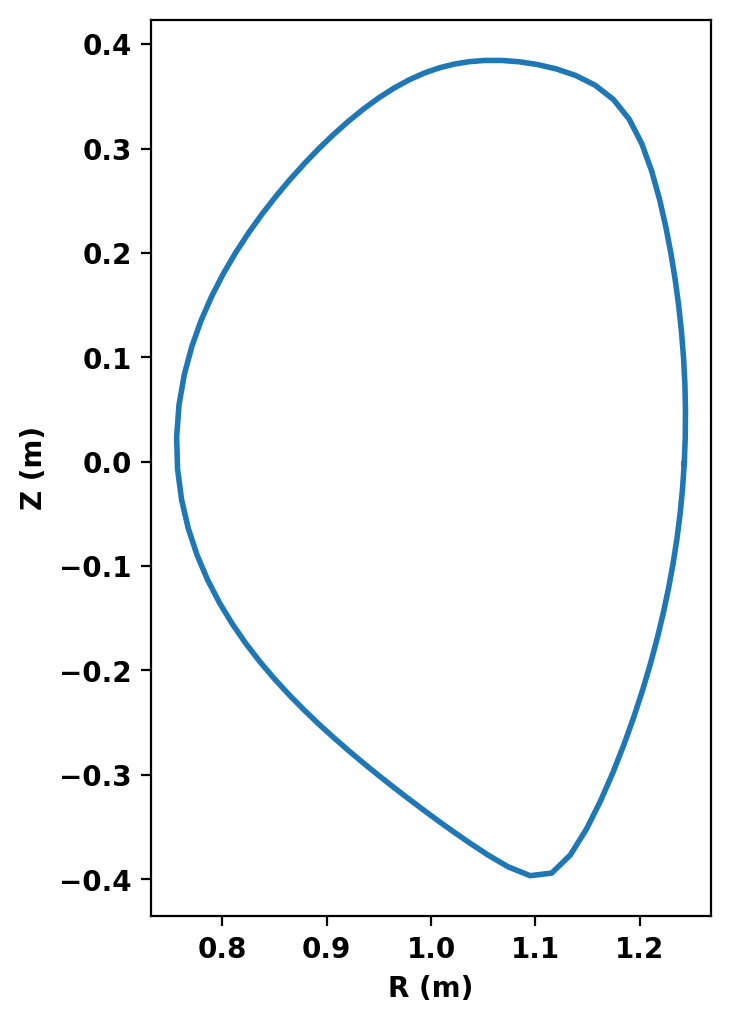

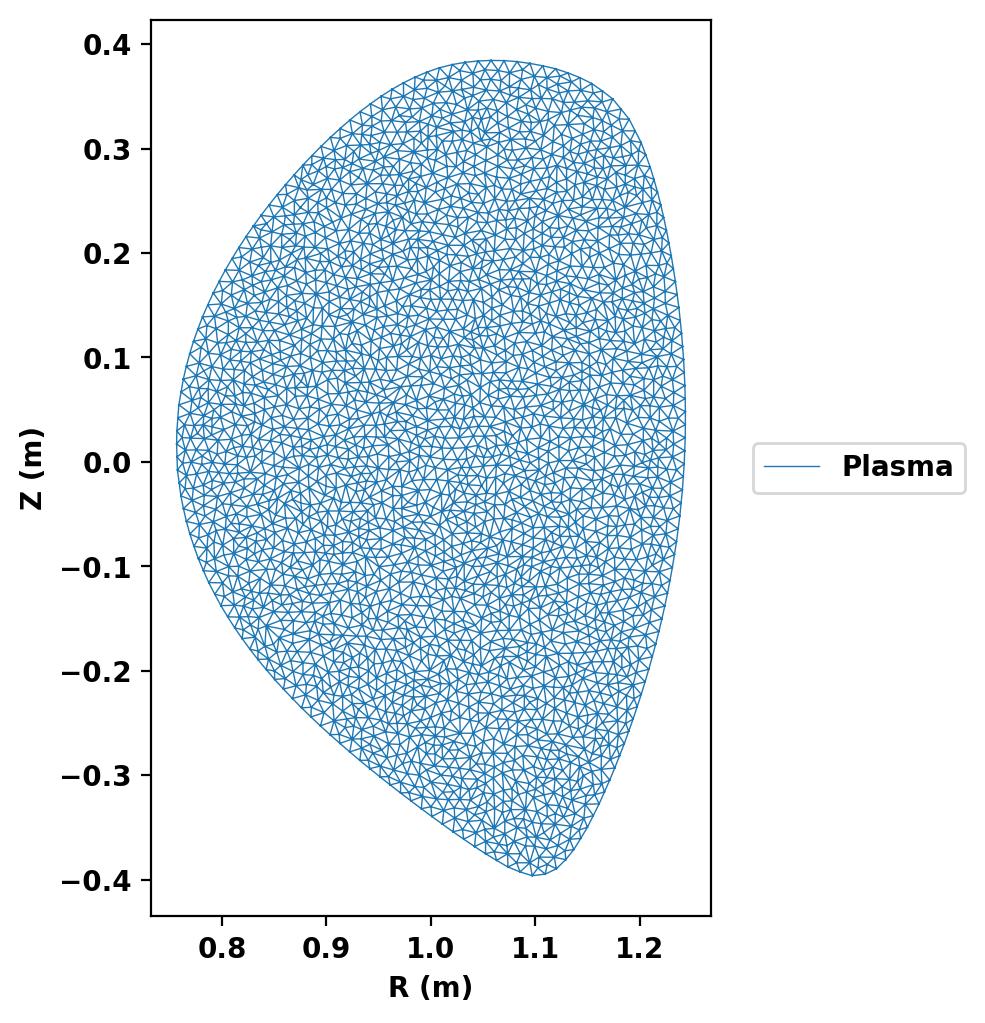

In [4]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('plasma',mesh_dx,'plasma')
# Define geometry for mesh
gs_mesh.add_polygon(LCFS_contour,'plasma',angle_tol=80.0)
#
fig, ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
gs_mesh.plot_topology(fig,ax)
# Generate mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
# Plot resulting mesh
fig, ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

In [5]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts,mesh_lc)
mygs.settings.free_boundary = False
mygs.settings.maxits = 60
mygs.setup(order=2,F0=EQ_in['rcentr']*EQ_in['bcentr'])

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_eddy_modes
Revision id:          c435b10
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.800E-01
    # of points  =    2842
    # of edges   =    8363
    # of cells   =    5522
    # of boundary points =     160
    # of boundary edges  =     160
    # of boundary cells  =     160
  Resolution statistics:
    hmin =  7.771E-03
    hrms =  1.138E-02
  

In [10]:
Ip_target = EQ_in['ip']
pax_target = EQ_in['pres'][0]
mygs.set_targets(Ip=Ip_target,pax=pax_target)

In [11]:
ffprim = EQ_in['ffprim']
pprime = EQ_in['pprime']


psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
psi_sample = np.linspace(0.0,1.0,np.size(ffprim))

psi_prof = np.copy(psi_sample)
ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})

Starting non-linear GS solver
     1  1.4353E+00  2.4262E-06  2.9748E-03  1.0265E+00  2.3911E-02  0.0000E+00
     2  1.7821E+00  1.5651E-06  1.1705E-03  1.0249E+00  2.3909E-02  0.0000E+00
     3  1.9114E+00  1.3673E-06  4.9220E-04  1.0239E+00  2.3915E-02  0.0000E+00
     4  1.9624E+00  1.3056E-06  2.1711E-04  1.0233E+00  2.3949E-02  0.0000E+00
     5  1.9829E+00  1.2840E-06  9.9780E-05  1.0229E+00  2.3989E-02  0.0000E+00
     6  1.9912E+00  1.2759E-06  4.7836E-05  1.0227E+00  2.4026E-02  0.0000E+00
     7  1.9946E+00  1.2727E-06  2.3968E-05  1.0226E+00  2.4058E-02  0.0000E+00
     8  1.9960E+00  1.2715E-06  1.2531E-05  1.0225E+00  2.4083E-02  0.0000E+00
     9  1.9966E+00  1.2710E-06  6.8008E-06  1.0224E+00  2.4101E-02  0.0000E+00
    10  1.9968E+00  1.2708E-06  3.8070E-06  1.0224E+00  2.4115E-02  0.0000E+00
    11  1.9969E+00  1.2707E-06  2.1874E-06  1.0224E+00  2.4125E-02  0.0000E+00
    12  1.9969E+00  1.2707E-06  1.2868E-06  1.0224E+00  2.4132E-02  0.0000E+00
    13  1.9970E+00  1.

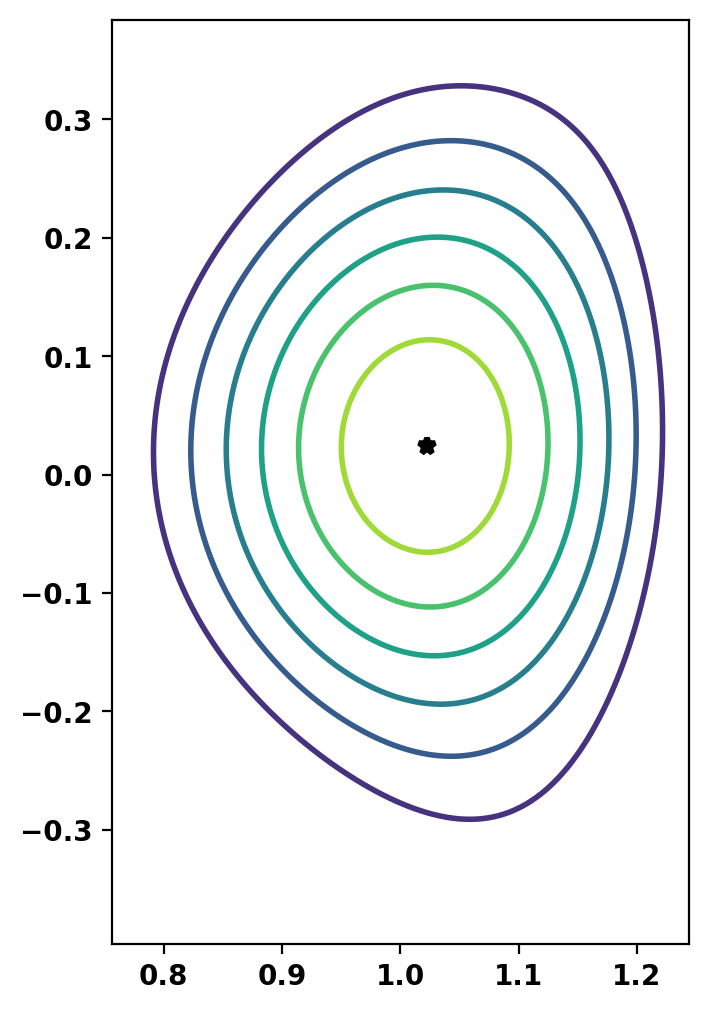

In [12]:
mygs.init_psi()
mygs.solve()
mygs.print_info()
fig, ax = plt.subplots(1,1)
mygs.plot_psi(fig,ax)

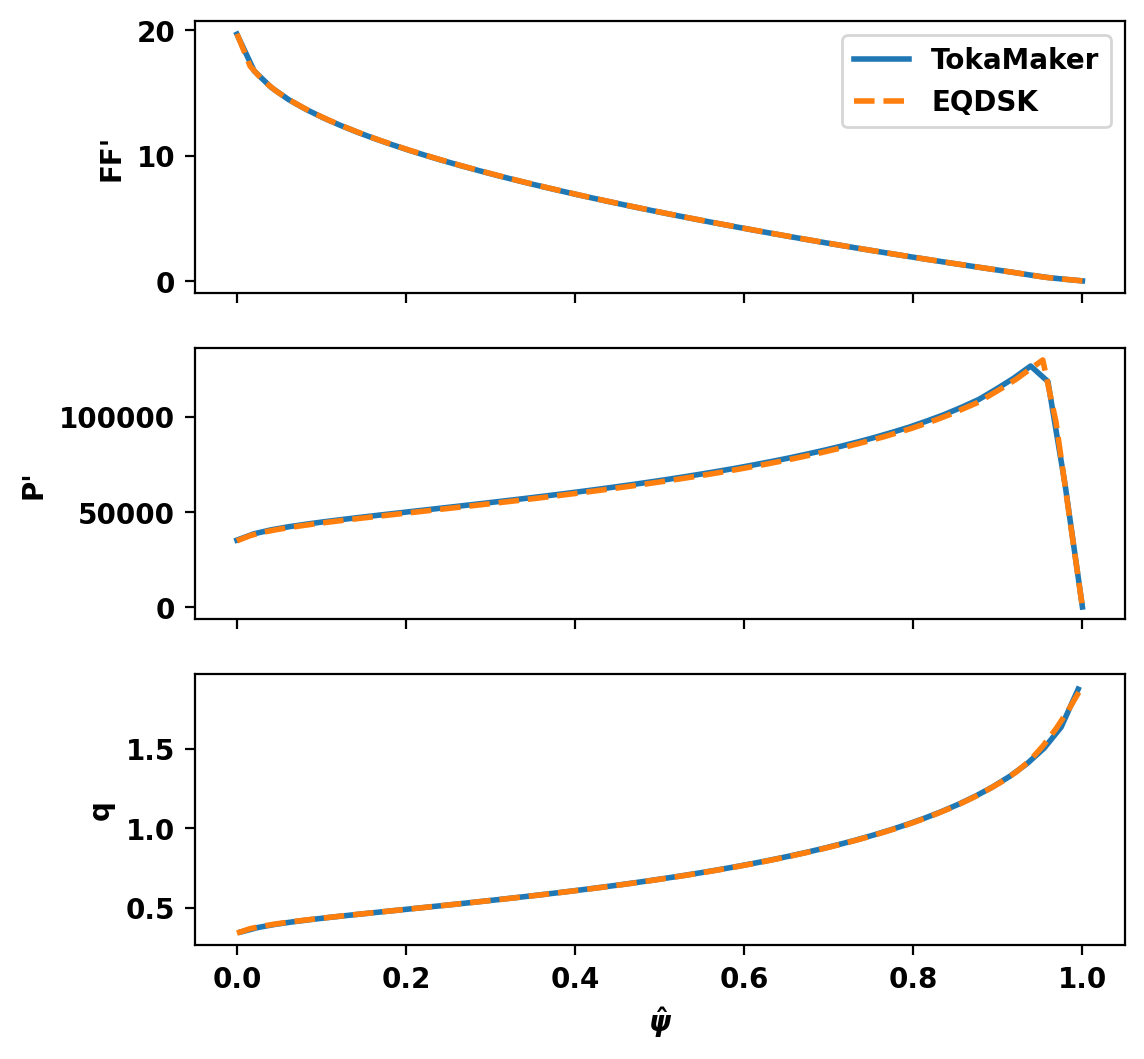

In [13]:
psi,f,fp,p,pp = mygs.get_profiles()
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.005)
fig, ax = plt.subplots(3,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,EQ_in['nr'])
psi_sample = np.linspace(0.025,1.0,10)
# Plot F*F'
ax[0].plot(psi,f*fp,label='TokaMaker')
ax[0].plot(psi_eqdsk,EQ_in['ffprim'],'--',label='EQDSK')
# ax[0].set_ylim(bottom=-10)
ax[0].set_ylabel("FF'")
ax[0].legend()
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,EQ_in['pprime'],'--')
# ax[1].set_ylim(top=2.E6)
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,EQ_in['qpsi'],'--')
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")